# Binomial, Poisson and Gaussian distributions

Python notebook for illustrating the Binomial, Poisson and Gaussian distributions and how they in certain limits converge towards each other (and in the end into the Gaussian). The notebook also illustrates simple fitting.

## References:
- Barlow: Chapter 3
- Cowan: Chapter 2
- Particle Data Group: __["Probability theorem and distributions"](https://pdg.lbl.gov/2022/reviews/rpp2022-rev-probability.pdf)__

## Author(s), contact(s), and dates:
- Author: Troels C. Petersen (NBI)
- Email:  petersen@nbi.dk
- Date:   23rd of November 2023

***

In [1]:
import numpy as np                                     # Matlab like syntax for linear algebra and functions
import matplotlib as mpl
import matplotlib.pyplot as plt                        # Plots and figures like you know them from Matlab
from iminuit import Minuit                             # The actual fitting tool, better than scipy's
import sys                                             # Modules to see files and folders in directories

from scipy import stats
from scipy.stats import binom, poisson, norm           # Functions from SciPy Stats...

Note that `SciPy Stats` has nearly every conceivable function implemented:
__["SciPy Stats functions"](https://docs.scipy.org/doc/scipy/reference/stats.html)__

In [2]:
sys.path.append('../../External_Functions')
from ExternalFunctions import Chi2Regression
from ExternalFunctions import nice_string_output, add_text_to_ax   # Useful functions to print fit results on figure

We set up the parameters for the program:

In [3]:
# General settings:
r = np.random                       # Random generator
r.seed(42)                          # Fixed order of random numbers

save_plots = False
verbose = True
N_verbose = 10

# Set plotting parameters:
mpl.rcParams['font.size'] = 18      # Set the general plotting font size

# Plotting PDFs:

First, we want to have a look at the three PDFs (Binomial, Poisson, and Gaussian), and compare them given "the same" parameters. Of course we can't give the same input parameters, but at least we can require that they have the same mean and widths... Almost - one can not force the width of the Poisson to match that of the Binomial, once the mean is matched. The Gaussian will then have to choose between these two slightly different widths!

### Problem parameters:
* The Binomial PDF needs two parameters: Number of trials (n) and probability of succes (p).
* The Poisson PDF needs one parameter:  The expected number (lambda - but in Python we write it "Lambda" or "lamp", as "lambda" is reserved!).
* The Gaussian PDF needs two parameters: Mean (mu) and width (sigma).

In [4]:
def func_binomial_pmf(x, n, p):
    return binom.pmf(x, n, p)

In [5]:
def func_poisson_pmf(x, lamb):
    return poisson.pmf(x, lamb)

In [6]:
def func_gaussian_pdf(x, mu, sigma) :
    return norm.pdf(x, mu, sigma)

In [7]:
# Range of outcome:
xmin = -0.5
xmax = 13.5

# Function parameters:
# Binomial:
n = 10
p = 0.2
# Poisson:
Lambda = n * p               # We choose this, as this is the expected number of successes.
# Gaussian:
mu = Lambda                  # Same here - the central value is n*p.
sigma = np.sqrt(n*p*(1-p))   # For a Binomial process, the variance is n*p*(1-p)
sigma = np.sqrt(n*p)         # Alternatively, one can use the Poisson width.
                             # Note how for small values of p, these expressions are essentially the same!!!

In [8]:
xaxis = np.linspace(xmin, xmax, 1000)
yaxis_binom = func_binomial_pmf(np.floor(xaxis+0.5), n, p)      # np.floor: See below
yaxis_poiss = func_poisson_pmf(np.floor(xaxis+0.5), Lambda)     # np.floor: See below
yaxis_gauss = func_gaussian_pdf(xaxis, n*p, np.sqrt(n*p*(1-p)))

# Note that the np.floor function takes the integer/rounded (towards zero) value of numbers.

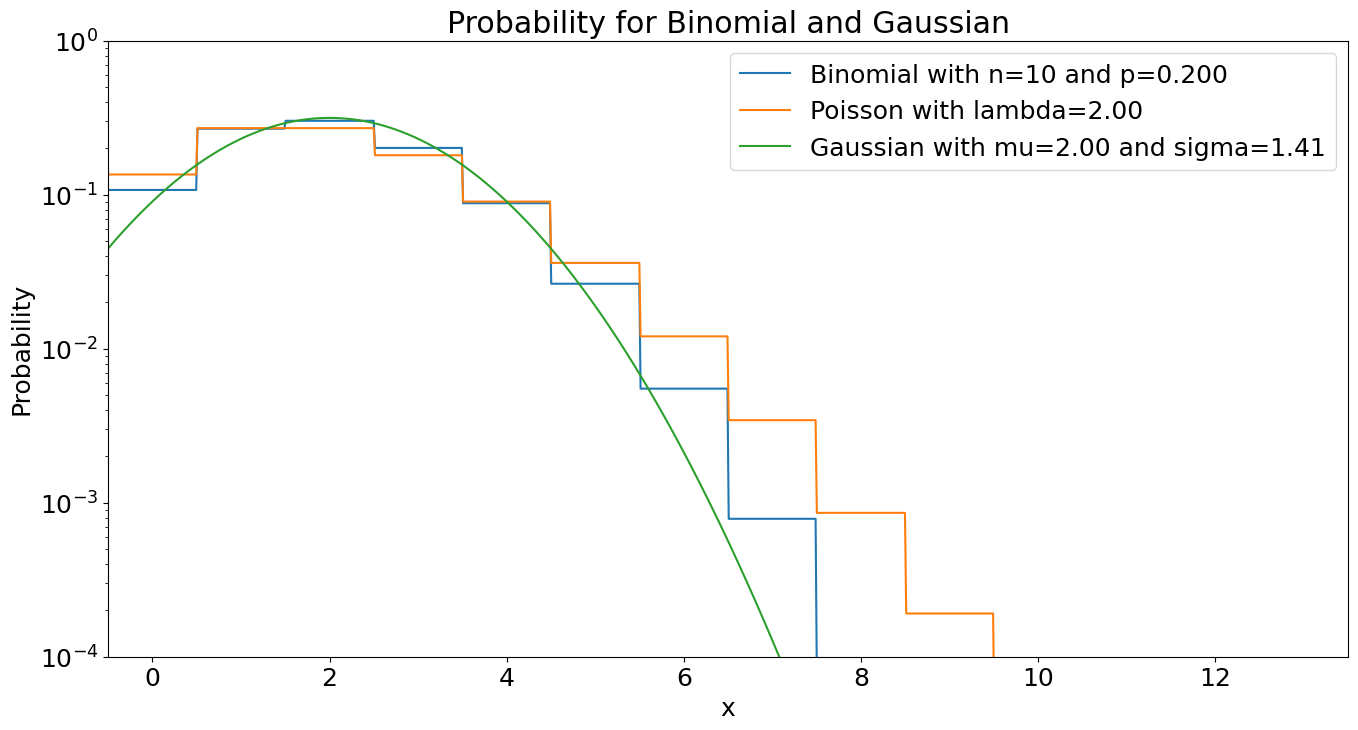

In [9]:
fig0, ax0 = plt.subplots(figsize=(16, 8))
ax0.plot(xaxis, yaxis_binom, '-', label=f'Binomial with n={n:2d} and p={p:.3f}')
ax0.plot(xaxis, yaxis_poiss, '-', label=f'Poisson with lambda={Lambda:.2f}')
ax0.plot(xaxis, yaxis_gauss, '-', label=f'Gaussian with mu={mu:.2f} and sigma={sigma:.2f}')
ax0.set(xlim=(xmin, xmax),
        title='Probability for Binomial and Gaussian', 
        xlabel='x', 
        ylabel='Probability')
ax0.set_yscale('log')
ax0.set_ylim(1e-4, 1.0)
ax0.legend(loc='upper right');

# Looping over processes:
In the following we simulate a Binomial/Poisson process with given parameters, i.e. number of trials and probability of success. For the Poisson, these can not be specified, but the resulting expected number is naturally lambda = n * p.

After having simulated the process, we fit the result with the three distributions in question, and test to what extend they match.

In [10]:
# Simulation parameters:
N_experiments = 1000              # Number of simulations/experiments to perform

N_trials = n                      # Number of trials in each experiment (taken from above!)
p_success = p                     # Chance of succes in each trial (taken from above!)
Lambda = N_trials * p_success     # This is the mean and the one parameter by which the Poisson is defined!

print(f"  With N_trials = {N_trials:d} and p_success = {p_success:.4f}, the average number of successes is lambda = {Lambda:.2f}")

  With N_trials = 10 and p_success = 0.2000, the average number of successes is lambda = 2.00


In [11]:
all_n_success = np.zeros(N_experiments)

# Run the experiments, and fill the histogram from above:
for iexp in range(N_experiments): 
    
    # Simulating process defined:
    n_success = 0
    for i in range(N_trials): 
        x = r.uniform()
        if (x < p_success): 
            n_success += 1

    # Record result:
    if (verbose and iexp < N_verbose < 50): 
        print(f"n_success: {n_success:4d}")
        
    # Save Result
    all_n_success[iexp] = n_success

n_success:    3
n_success:    3
n_success:    3
n_success:    3
n_success:    3
n_success:    3
n_success:    2
n_success:    4
n_success:    1
n_success:    3


## Plot result:

Define a histogram with the "data" (note and think about the binning!). Also, ask yourself what uncertainty to assign to each bin?<br>
The line of thinking should be: "There are many possibilities of ending up in a specific bin, but the probability of doing so is each low".

In [12]:
counts, bin_edges = np.histogram(all_n_success, bins=N_trials+1, range=(-0.5, N_trials+0.5))
bin_centers = (bin_edges[1:] + bin_edges[:-1])/2
s_counts = np.sqrt(counts)                         # NOTE: We (naturally) assume that the bin count is Poisson distributed.

In [13]:
# We remove any bins, which don't have any counts in them (for Chi2 fitting):
x = bin_centers[counts>0]
y = counts[counts>0]
sy = s_counts[counts>0]

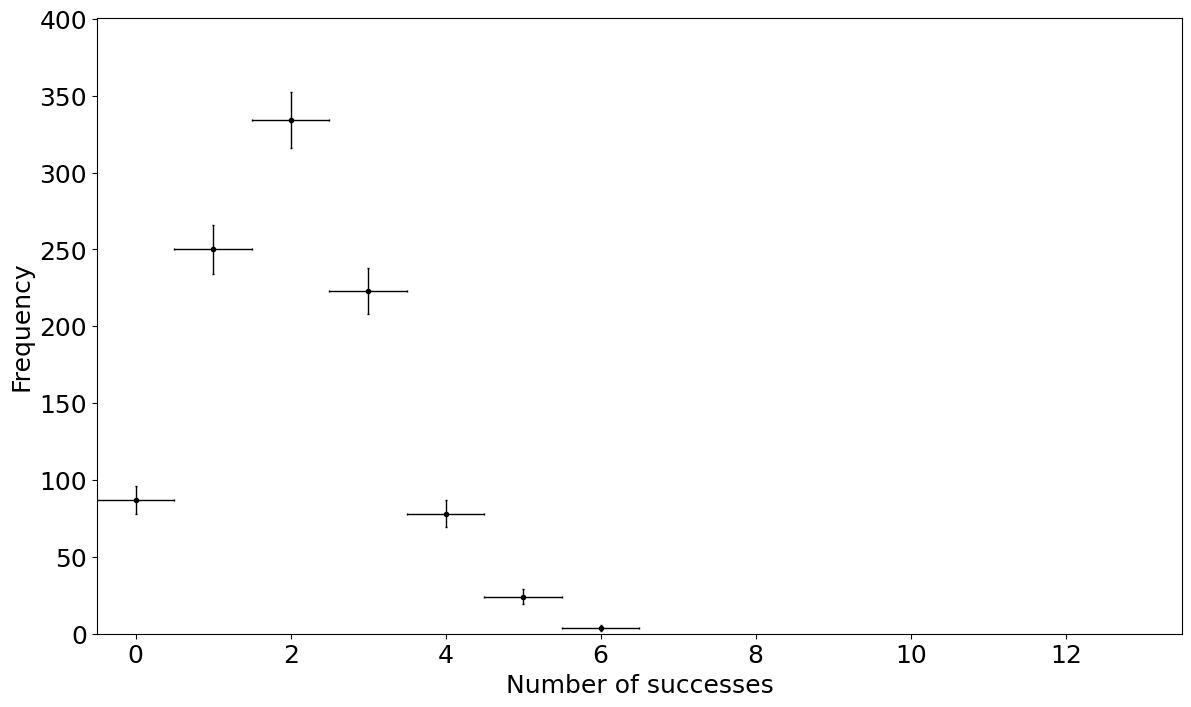

In [14]:
fig, ax = plt.subplots(figsize=(14, 8))
ax.errorbar(x, y, yerr=sy, xerr=0.5, label='Distribution of nSuccesses', fmt='.k',  ecolor='k', elinewidth=1, capsize=1, capthick=1)
ax.set(xlim=(xmin, xmax), ylim=(0, 1.2*np.max(y)), xlabel='Number of successes', ylabel='Frequency');

## Fitting with a Binomial:

First define the (fitting) function:

In [15]:
def func_binomial(x, N, n, p):
    return N * binom.pmf(x, n, p)

Then fit it with a $\chi^2$-fit:

In [16]:
Minuit.print_level = 1

chi2_bin = Chi2Regression(func_binomial, x, y, sy)
chi2_bin.errordef = 1
minuit_bin = Minuit(chi2_bin, N=N_experiments, n=N_trials, p=p_success) #   
minuit_bin.migrad()          # Perform the actual fit


/Users/ludvigwitschel/Desktop/Physics Bachelor/Applied Statistics/AppStat Repo/Week2/BinomialPoissonGauss/../../External_Functions/ExternalFunctions.py:113: VisibleDeprecationWarning: make_func_code is deprecated: Use of ``func_code`` attribute to declare parameters is deprecated. Use ``_parameters`` instead, which is a dict of parameter names to limits.
  self.func_code = make_func_code(describe(self.f)[1:])


┌─────────────────────────────────────────────────────────────────────────┐
│                                Migrad                                   │
├──────────────────────────────────┬──────────────────────────────────────┤
│ FCN = 13.42                      │              Nfcn = 172              │
│ EDM = nan (Goal: 0.0002)         │                                      │
├──────────────────────────────────┼──────────────────────────────────────┤
│         INVALID Minimum          │   ABOVE EDM threshold (goal x 10)    │
├──────────────────────────────────┼──────────────────────────────────────┤
│      No parameters at limit      │           Below call limit           │
├──────────────────────────────────┼──────────────────────────────────────┤
│             Hesse ok             │         Covariance accurate          │
└──────────────────────────────────┴──────────────────────────────────────┘
┌───┬──────┬───────────┬───────────┬────────────┬────────────┬─────────┬─────────┬───────┐
│   │ Name │   Value   │ Hesse Err │ Minos Err- │ Minos Err+ │ Limit-  │ Limit+  │ Fixed │
├───┼──────┼───────────┼───────────┼────────────┼────────────┼─────────┼─────────┼───────┤
│ 0 │ N    │    1e3    │    nan    │            │            │         │         │       │
│ 1 │ n    │    1e1    │    nan    │            │            │         │         │       │
│ 2 │ p    │   2e-1    │    nan    │            │            │         │         │       │
└───┴──────┴───────────┴───────────┴────────────┴────────────┴─────────┴─────────┴───────┘
┌───┬─────────────┐
│   │   N   n   p │
├───┼─────────────┤
│ N │ nan nan nan │
│ n │ nan nan nan │
│ p │ nan nan nan │
└───┴─────────────┘

And plot it on the figure:

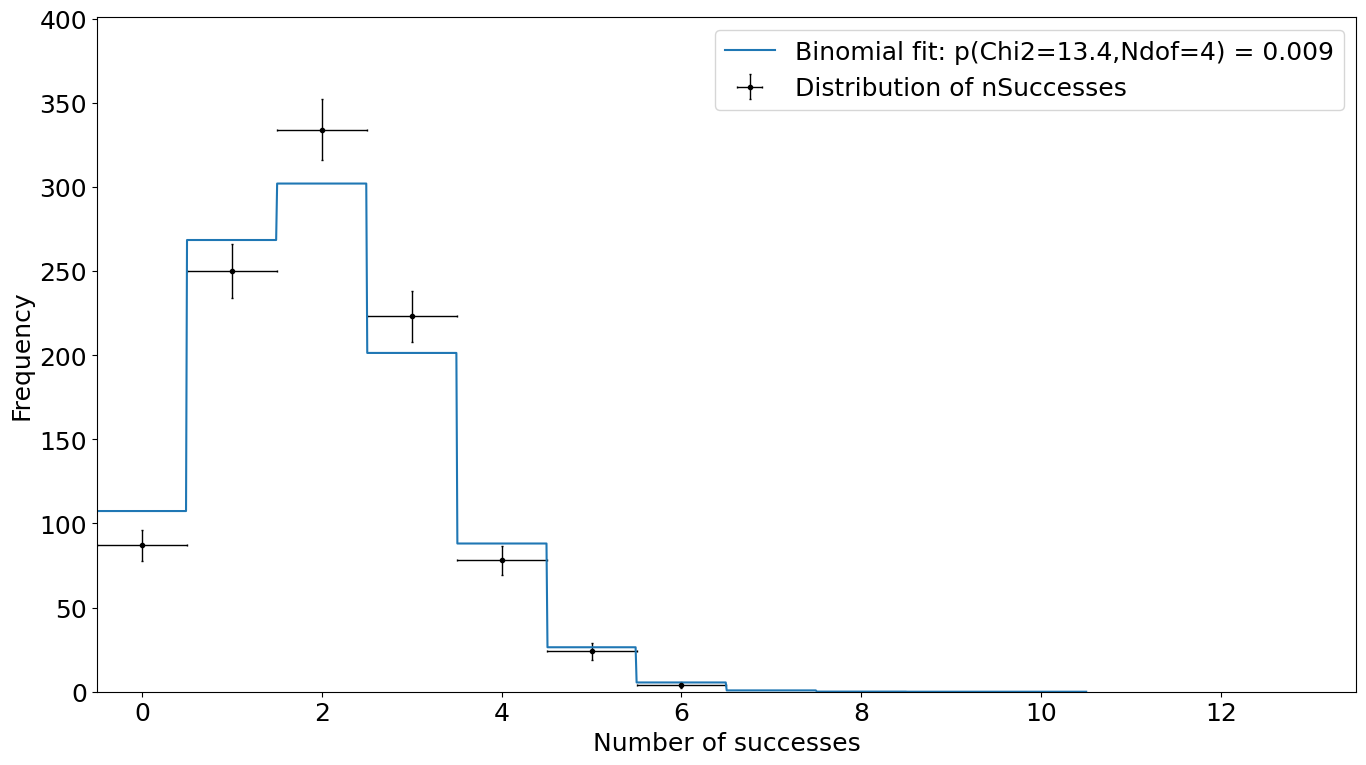

In [17]:
Chi2_bin = minuit_bin.fval
Ndof_bin = len(x) - 3        # 3 parameters in fit
Prob_bin = stats.chi2.sf(Chi2_bin, Ndof_bin)

xaxis = np.linspace(-0.5, N_trials+0.5, 1000)                  # This way we include all possibilties!
yaxis = func_binomial(np.floor(xaxis+0.5), *minuit_bin.values[:])
ax.plot(xaxis, yaxis, '-', label=f'Binomial fit: p(Chi2={Chi2_bin:.1f},Ndof={Ndof_bin:d}) = {Prob_bin:.3f}')
ax.legend()
fig.tight_layout()
fig

## Fitting with a Poisson:

In [18]:
def func_poisson(x, N, mu) :
    return N * poisson.pmf(x, mu)

In [19]:
chi2_poisson = Chi2Regression(func_poisson, x, y, sy)
chi2_poisson.errordef = 1
minuit_poisson = Minuit(chi2_poisson, N=N_experiments, mu=Lambda) #   
minuit_poisson.migrad();           # Perform the actual fit (without printing)
Chi2_poi = minuit_poisson.fval
Ndof_poi = len(x) - 2              # 2 parameters in fit
Prob_poi = stats.chi2.sf(Chi2_poi, Ndof_poi)

/var/folders/h1/5m32rx1j3v939581npzbyxpr0000gn/T/ipykernel_30493/3661716162.py:4: UserWarning: The figure layout has changed to tight
  fig.tight_layout()


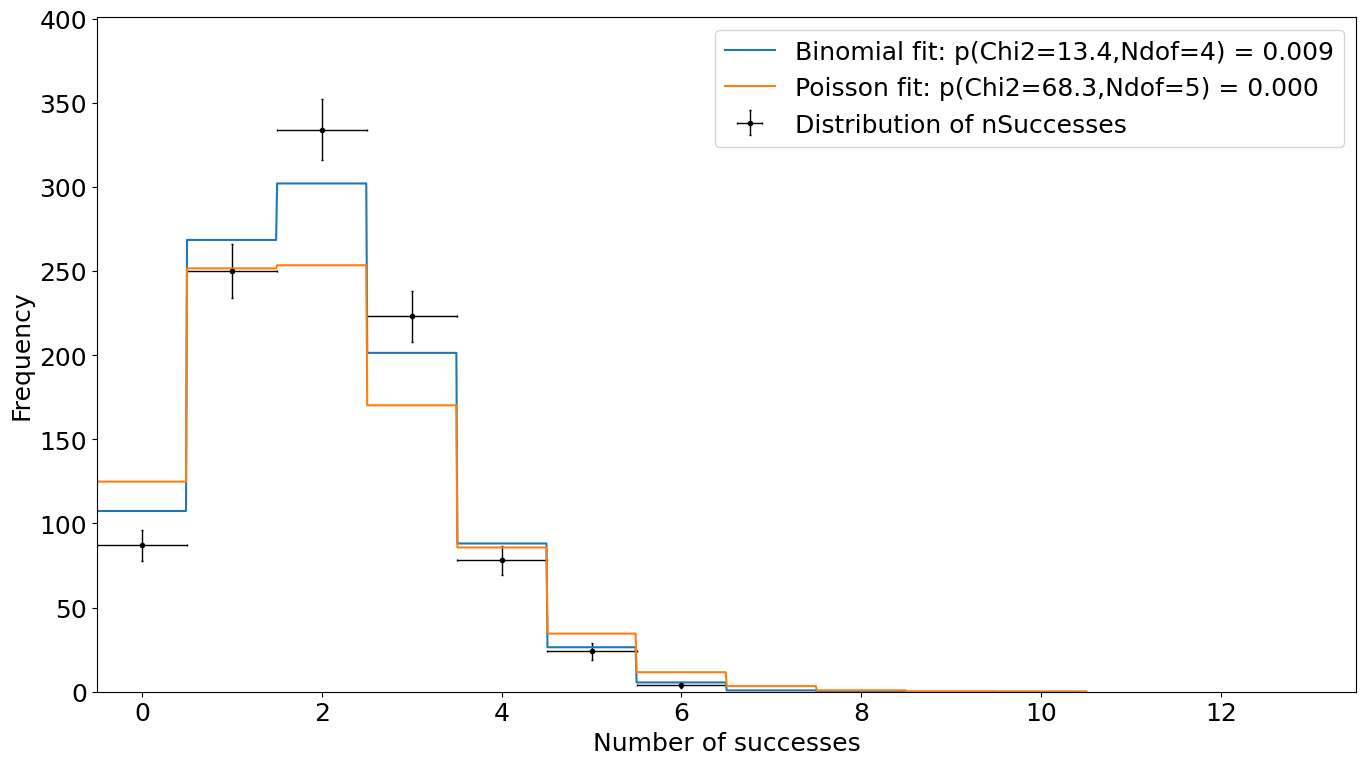

In [20]:
yaxis = func_poisson(np.floor(xaxis+0.5), *minuit_poisson.values[:])
ax.plot(xaxis, yaxis, '-', label=f'Poisson fit: p(Chi2={Chi2_poi:.1f},Ndof={Ndof_poi:d}) = {Prob_poi:.3f}')
ax.legend()
fig.tight_layout()
fig

## Fitting with a Gaussian:

In [21]:
def func_gaussian(x, N, mu, sigma) :
    return N * norm.pdf(x, mu, sigma)

In [22]:
chi2_gaussian = Chi2Regression(func_gaussian, x, y, sy)
chi2_gaussian.errordef = 1
minuit_gaussian = Minuit(chi2_gaussian, N=N_experiments, mu=Lambda, sigma=np.sqrt(Lambda)) #   
minuit_gaussian.migrad();       # Perform the actual fit
Chi2_gau = minuit_gaussian.fval
Ndof_gau = len(x) - 3           # 3 parameters in fit
Prob_gau = stats.chi2.sf(Chi2_gau, Ndof_gau)

/var/folders/h1/5m32rx1j3v939581npzbyxpr0000gn/T/ipykernel_30493/205969718.py:4: UserWarning: The figure layout has changed to tight
  fig.tight_layout()


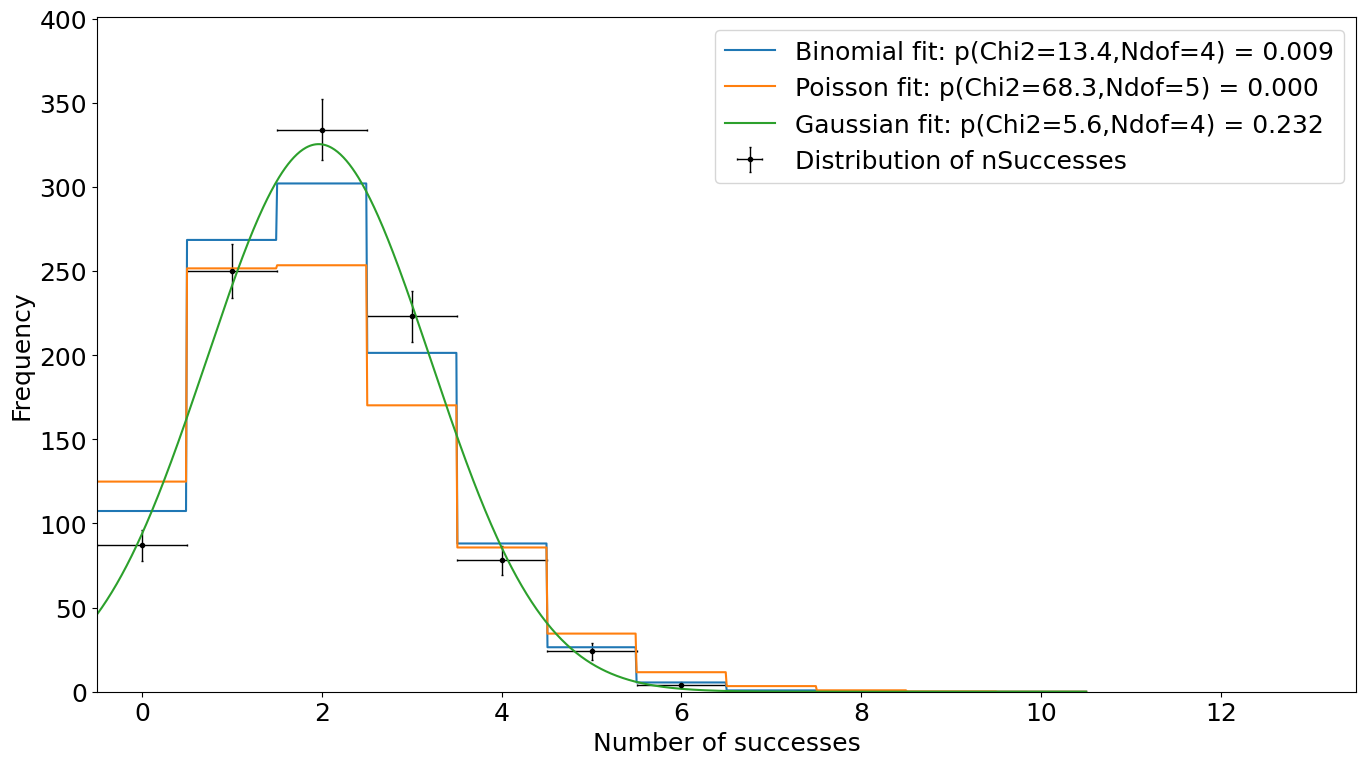

In [23]:
yaxis = func_gaussian(xaxis, *minuit_gaussian.values[:])
ax.plot(xaxis, yaxis, '-', label=f'Gaussian fit: p(Chi2={Chi2_gau:.1f},Ndof={Ndof_gau:d}) = {Prob_gau:.3f}')
ax.legend()
fig.tight_layout()
fig

And save the figure:

In [24]:
if save_plots: 
    fig.savefig("BinomialPoissonGaussian.pdf")

## Calculation of Binomial $\chi^2$-value:

In this part of the exercise, you are asked to calculate the ChiSquare value yourself, in order to ensure that you understand exactly what is going on!

Above, we have (using Minuit) *fitted* the distribution, but as we know the initial values, I would like you to calculate the $\chi^2$-value between the data and the binomial they were generated from, i.e. with NO free parameters.

I suggest you use Pearson's $\chi^2$, and require `N_obs` and/or `N_exp` > e.g. 0.1. Remember that your choice should ensure, that there is no division by zero (which is a cardinal sin in programming)!

In [25]:
N_bins = len(x)                # Just to know how many bins to loop over
Ybino = func_binomial(x, *minuit_bin.values[:]) #expected values. 
if Ybino.all() >= 0:
    chi2_bino = np.sum(((y - Ybino) / (Ybino))**2, axis = 0)                # This you'll add to

# Samme for Poisson og Gauss
Ypois = func_poisson(x, *minuit_poisson.values[:])
if Ypois.all() >= 0:
    chi2_pois = np.sum(((y - Ypois) / (Ypois))**2, axis = 0) 

Ygauss = func_gaussian(x, *minuit_gaussian.values[:])
if Ygauss.all() >= 0:
    chi2_gauss = np.sum(((y - Ygauss) / (Ygauss))**2, axis = 0) 



In [26]:
for N_obs, x_i in zip(y, x):
    N_exp = func_binomial(x_i, N_experiments, N_trials, p_success)
    if (N_obs > 0) :
        chi2_bino += 0.0       # Write the expression yourself!

# Also calculate Ndof and Prob:
Ndof_bino = 1                  # Think about/write the number of degrees of freedom given no free parameters!

Prob_bino = stats.chi2.sf(chi2_bino, Ndof_bino)

In [27]:
print(f"Binomial:   chi2 = {chi2_bino:.2f}   N_dof = {Ndof_bino:d}   Prob = {Prob_bino:6.4f}")

Binomial:   chi2 = 0.16   N_dof = 1   Prob = 0.6893


***


# Questions:

Important: Make sure you understand what process yields a Binomial, a Poisson and a Gaussian distribution. Without this knowledge, this exercise and a large fraction of the course will be lost on you!

1. Plot a Binomial ($N=20$, $p=0.2$), Poisson ($\lambda = 4$), and Gaussian ($\mu=4$, $\sigma=\sqrt{4}$), i.e. same means and widths. Which distribution has the longest tail towards high values? And which one has the longest tail the other way? Does this pattern depend on the parameters (given same means and widths)? Play around with the settings (remember also to change the scale (use log) of the plot accordingly), and gain your own experience. And most importantly perhaps, in what limits do they start looking like each other?

2. Producing binomially distributed numbers (using the parameters `N_experiments=1000`, `N_trials=10` and `p_success=0.2`), do $\chi^2$ fits of the resulting distribution with a Binomial, a Poisson, and a Gaussian distribution. Do you get acceptable fit probabilities with all of these? If not, investigate for what choice of parameters you do.

3. Calculate the $\chi^2$ between the data and the original Binomial distribution (which the data is generated from). Since you are not fitting anything, what is the number of degrees of freedom? Does it give a reasonable $\chi^2$-probability?

4. In all of the above $\chi^2$ fits, we have _assumed_ that the uncertainty on the count in each bin is Gaussianly distributed! Ask yourself to what extend this requirement is fulfilled? Does changing the parameters (`N_experiments`, `N_trials` and `p_success`) "help" fulfilling this requirement, and if so, which and how?

### Advanced questions:

5. Using `N_experiments=1000`, `N_trials=1000` and `p_success=1/60`, is the skewness consistent with zero (as the Gaussian should have)?

1. Towards high values, the Poisson distribution has the largest tail.



2. The Poisson does not fit well!

3. $N_{dof} = 11 - 3 = 8$. Yes, $p = 0.370$ is very reasonable. 

4. If $N_{trials}$ is high, $p_{success}$ is low - in each bin!



# Learning points:

Generally, you should understand the concept of a PDF, and that there are many such, though in this course we only consider 10 or so. Some are *continuous* (e.g. exponential and Gaussian) and some are *discrete* (e.g. Binomial and Poisson).

In this exercise, you should have learned:
1. What the conditions leading to a Binomial and a Poisson distribution are.
2. In what limit of $N_{trials}$ and $p_{succes}$ the Binomial converges towards the Poisson.
3. That in the limit of $N_{trials} \times p_{succes} \to \infty$ and $\lambda \to \infty$, the two distributions become Gaussian (though discrete).
4. **That the uncertainty on a Poisson number is the square root of that number**.

One consequence of 4), is that we choose number of counts in a bin $N$ to have $\sqrt{N}$ as uncertainty. It should be noted, that for low $N$, the uncertainty is not very Gaussian.

You should also have learned how to choose binning when making a histogram of integers. 